Install Required Libraries

In [3]:
!pip install pandas numpy scikit-learn shap matplotlib seaborn


Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Load & Understand Data

In [5]:
df = pd.read_csv("/content/loan_data.csv")
df.head()


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Basic Data Cleaning

In [6]:
df.isnull().sum()


,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


In [10]:
df = df.dropna()

Encode Categorical Features

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for col in df.select_dtypes(include='object'):
    df[col] = encoder.fit_transform(df[col])


Split Features & Target

In [12]:
X = df.drop("loan_status", axis=1)
y = df["loan_status"]


Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train ML Model

In [14]:
from sklearn.ensemble import RandomForestClassifier

loan_model = RandomForestClassifier(random_state=42)
loan_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Model Evaluation

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = loan_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9286666666666666
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6990
           1       0.89      0.78      0.83      2010

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.93      0.93      0.93      9000



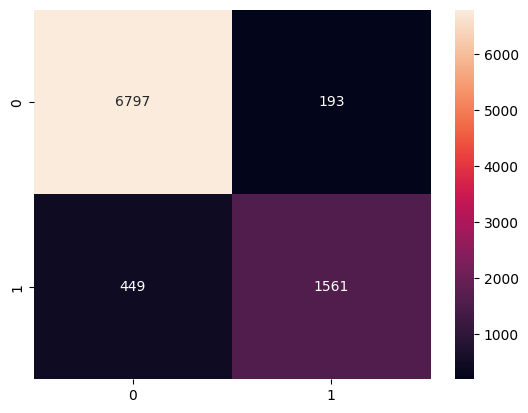

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()


EXPLAINABLE AI – SHAP

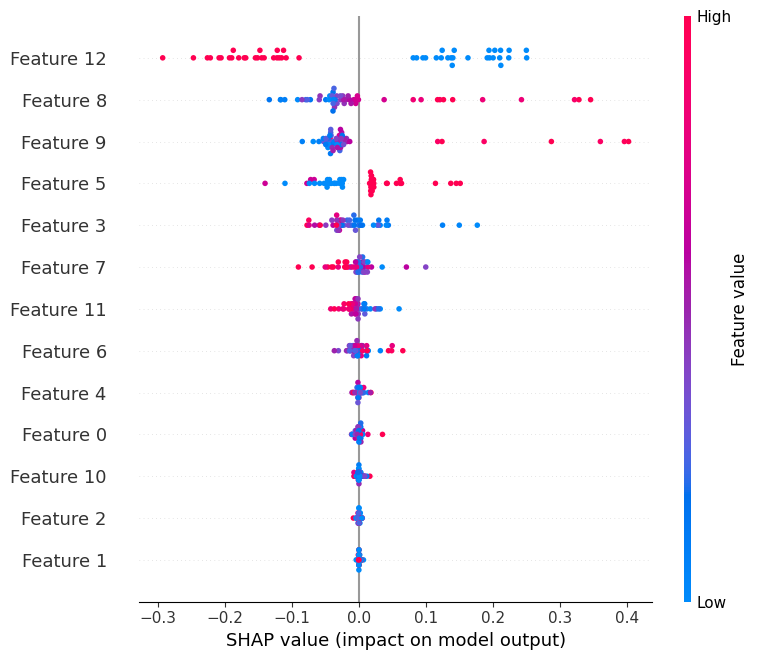

In [24]:
import shap

# Take a small representative sample
X_shap = X_test.sample(50, random_state=42)

explainer = shap.TreeExplainer(loan_model)
shap_values = explainer.shap_values(X_shap)

# For binary classification, use index 1 (Approved class)
# The shap_values array is typically (num_samples, num_features, num_classes)
# So, to get values for class 1 across all samples and features, use[:, :, 1]
shap.summary_plot(shap_values[:, :, 1], X_shap.values)

In [27]:
# Pick one test sample
sample = X_test.iloc[[0]]

# Predict loan decision
prediction = loan_model.predict(sample)[0]

print("Final Loan Decision:", "Approved" if prediction == 1 else "Rejected")


Final Loan Decision: Rejected


In [28]:
# Calculate SHAP values for the selected applicant
shap_sample_values = explainer.shap_values(sample)


In [30]:
import numpy as np

# For binary classification, index 1 = Approved class
# shap_sample_values is (num_samples, num_features, num_classes)
# Access the first sample (index 0) and the Approved class (index 1)
shap_vals = shap_sample_values[0, :, 1]

# Get top 3 features with highest negative impact
feature_impact = pd.DataFrame({
    "Feature": sample.columns,
    "SHAP_Value": shap_vals
})

# Sort by SHAP value (negative impact first)
feature_impact = feature_impact.sort_values(by="SHAP_Value")

top_negative_reasons = feature_impact.head(3)

In [31]:
print("\nAI Explanation for Loan Rejection:")

for _, row in top_negative_reasons.iterrows():
    print(f"- {row['Feature']} had a negative impact on loan approval")



AI Explanation for Loan Rejection:
- loan_int_rate had a negative impact on loan approval
- person_income had a negative impact on loan approval
- loan_percent_income had a negative impact on loan approval


In [32]:
print("\nDetailed SHAP Impact Values:")
print(top_negative_reasons)



Detailed SHAP Impact Values:
               Feature  SHAP_Value
8        loan_int_rate   -0.116073
3        person_income   -0.070992
9  loan_percent_income   -0.055283


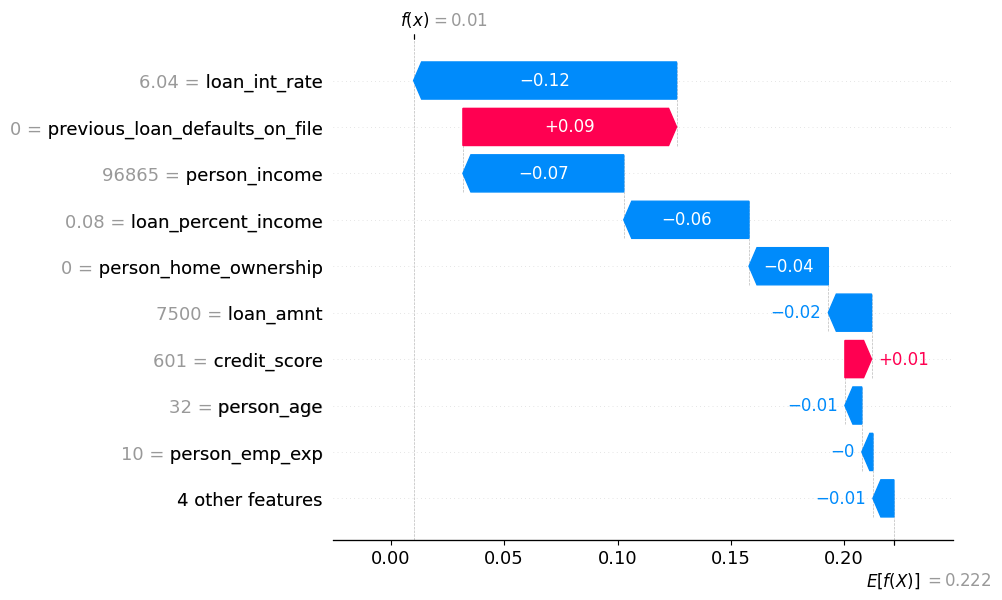

In [34]:
shap.waterfall_plot(
    shap.Explanation(
        values=shap_sample_values[0, :, 1], # Corrected indexing for single sample, second class
        base_values=explainer.expected_value[1],
        data=sample.iloc[0],
        feature_names=sample.columns
    )
)